In [24]:
import os, sys

# Root project
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to sys.path:", project_root)


# Imports
from stn_gpe import *
import numpy as np
from matplotlib import pyplot as plt
import scipy
from numpy.fft import fft, ifft
import math
from scipy.signal import spectrogram
from matplotlib.lines import Line2D

from matplotlib.colors import LinearSegmentedColormap
# rc styling (Times New Roman + nicer defaults)
# ...existing code...
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 12,
    "font.weight": "bold",         # global bold
    "axes.titlesize": 12,
    "axes.titleweight": "bold",    # bold axis titles
    "axes.labelsize": 11,
    "axes.labelweight": "bold",    # bold axis labels
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
    "axes.grid": False
})
# ...existing code...

Project root added to sys.path: /Users/charithapalika/Desktop/Lab projects/WORKSHOP/BG project


## Run STN-GPe system

In [25]:
# Parameters file
yaml_path = os.path.join(project_root, 'params', 'stn_gpe_params', 'params_calibration.yaml')
arguments = load_yaml(yaml_path)
arguments['lat_strength_stn'] = 0.02
arguments['I_strd2_gpe'] = 5
arguments['DBS'] = True
# Simulate STN-GPe system
temp_file = 'temp.yaml'
save_yaml(arguments, temp_file)
results = STN_GPe_loop(temp_file)

  0%|          | 0/50000 [00:00<?, ?it/s]

## Analysis

In [26]:
V_stn_time_all = np.array(results['v_stn'])
V_gpe_time_all = np.array(results['v_gpe'])
spike_monitor_stn = results['spike_stn']
spike_monitor_gpe = results['spike_gpe']
lfp_stn = results['lfp_stn']
lfp_gpe = results['lfp_gpe']
I_DBS = results['I_DBS']

In [27]:
iter = arguments.get('time')
h = arguments.get('dt')
t_low = 40000
t_high = 50000
t_chunk = np.linspace(0,(t_high-t_low)*h/1000,t_high - t_low)
t = np.linspace(0,iter*h/1000,iter)


#************************Analysis**************************************
analysis_STN = Analysis(spike_monitor_stn[t_low:t_high])
analysis_GPe = Analysis(spike_monitor_gpe[t_low:t_high])


# ************************* FFT ***************************************
lfp_smooth_stn = scipy.signal.savgol_filter(lfp_stn[t_low-10000:t_high], window_length=11, polyorder = 5, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
lfp_smooth_gpe = scipy.signal.savgol_filter(lfp_gpe[t_low-10000:t_high], window_length=11, polyorder = 5, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
sr = 10000
fft_output_stn = fft(lfp_stn)
fft_output_gpe = fft(lfp_smooth_gpe)
N = len(fft_output_stn)
n = np.arange(N)
T = N/sr
freq = n/T

# ***********************Spectrogram***********************************
fs = 10000  # sampling frequency
window_size = 10000 #10000  # 100ms window
overlap = 950 
nperseg = window_size
noverlap = overlap

# STN Spectrogram
f_stn, t_spec_stn, Sxx_stn = scipy.signal.spectrogram(lfp_smooth_stn, fs=fs, 
                                                      nperseg=nperseg, 
                                                      noverlap=noverlap, 
                                                      window='hamming')  # Changed from 'hanning' to 'hamming'

# GPe Spectrogram
f_gpe, t_spec_gpe, Sxx_gpe = scipy.signal.spectrogram(lfp_smooth_gpe, fs=fs, 
                                                      nperseg=nperseg, 
                                                      noverlap=noverlap, 
                                                      window='hamming')  # Changed from 'hanning' to 'hamming'


# **************************Spectral entropy***************************
avg_entropy_stn = analysis_STN.spectral_entropy(signal=lfp_stn[t_low:t_high],
                                   fs = 10000,
                                   nperseg = 10000,
                                   fmax = 35,
                                   normalize = True)
avg_entropy_gpe = analysis_GPe.spectral_entropy(signal=lfp_gpe[t_low:t_high],
                                   fs = 10000,
                                   nperseg = 10000,
                                   fmax = 35,
                                   normalize = True)


# ***************************Synchrony********************************
R_sync_stn, Ravg_stn = analysis_STN.synchrony()
R_sync_gpe, Ravg_gpe = analysis_GPe.synchrony()


# **************************Rate Output******************************
# spike to rate conversion
rate_data = analysis_STN.spike_rate(binsize = 100)

stn_a, stn_b, stn_c, stn_d = rate_data['1'], rate_data['2'], rate_data['3'], rate_data['4']
rate_all = rate_data['all_rate_data']
preprocessed_stn = rate_data['preprocessed_stn']
processed_stn = rate_data['processed_stn']
mean_std = rate_data['mean_std']
max_std = rate_data['max_std']
min_std = rate_data['min_std']

#**************************Frequency*******************************
frequency_avg_STN, frequency_max_STN, frequency_min_STN = analysis_STN.frequency(dt = h)

frequency_avg_GPe, frequency_max_GPe, frequency_min_GPe = analysis_GPe.frequency(dt = h)


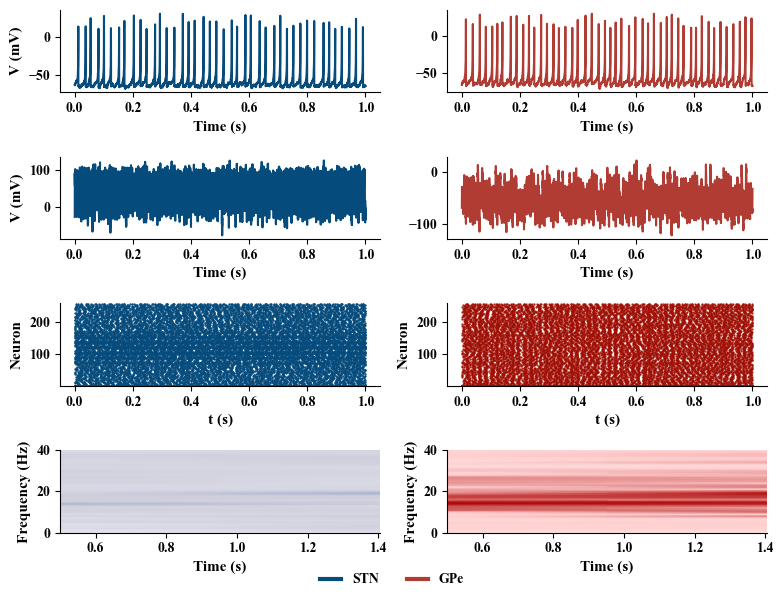

In [28]:
fig, axs = plt.subplots(4, 2, figsize=(8, 6), facecolor='white', 
                       gridspec_kw={'height_ratios': [1, 1, 1, 1]})
fig.patch.set_visible(True)
fig.patch.set_facecolor('white')
fig.patch.set_edgecolor('white')
fig.patch.set_linewidth(0)
fig.subplots_adjust(wspace=0.3, left=0.06, right=0.98, top=0.95, bottom=0.08, hspace=0.4)

colors = {'STN':"#054b7c",
          'GPe': "#9f0d03ce"}

# STN voltage
axs[0, 0].plot(t_chunk, V_stn_time_all[t_low:t_high, 15, 15], color=colors['STN'])
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("V (mV)")
# axs[0, 0].legend(["STN"], loc="upper right", frameon=False, bbox_to_anchor=(1.0, 1.2))

# GPe voltage
axs[0, 1].plot(t_chunk, V_gpe_time_all[t_low:t_high, 7,7], color=colors['GPe'])
axs[0, 1].set_xlabel("Time (s)")
# axs[0, 1].legend(["GPe"], loc="upper right", frameon=False, bbox_to_anchor=(1.0, 1.2))

# STN LFP
axs[1, 0].plot(t_chunk, lfp_stn[t_low:t_high], color=colors['STN'])
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("V (mV)")

# GPe LFP
axs[1, 1].plot(t_chunk, lfp_gpe[t_low:t_high], color=colors['GPe'])
axs[1, 1].set_xlabel("Time (s)")

# Raster scan STN
spike_array_stn = np.array(spike_monitor_stn[t_low:t_high])
num_neurons_stn = spike_array_stn.shape[1]
time_steps_stn = spike_array_stn.shape[0]
t_raster = np.linspace(0, time_steps_stn * h / 1000, time_steps_stn)
for n in range(num_neurons_stn):
    axs[2, 0].scatter(t_raster, (n + 1) * spike_array_stn[:, n], color=colors['STN'], s=0.5)
axs[2, 0].set_ylim(0.5, num_neurons_stn + 0.5)
axs[2, 0].set_xlabel("t (s)")
axs[2, 0].set_ylabel("Neuron")
# axs[2, 0].set_title("STN Raster Scan")

# Raster scan GPe
spike_array_gpe = np.array(spike_monitor_gpe[t_low:t_high])
num_neurons_gpe = spike_array_gpe.shape[1]
time_steps_gpe = spike_array_gpe.shape[0]
t_raster_gpe = np.linspace(0, time_steps_gpe * h / 1000, time_steps_gpe)
for n in range(num_neurons_gpe):
    axs[2, 1].scatter(t_raster_gpe, (n + 1) * spike_array_gpe[:, n], color=colors['GPe'], s=0.5)
axs[2, 1].set_ylim(0.5, num_neurons_gpe + 0.5)
axs[2, 1].set_xlabel("t (s)")
axs[2, 1].set_ylabel("Neuron")

colors_blue = [
    (1, 1, 1),        # Pure white
    (0.98, 0.98, 1),  # Almost white with tiny blue tint
    (0.95, 0.95, 1),  # Very slight blue tint
    (0.9, 0.9, 0.95), # Very slight blue tint,
    (0.89, 0.89, 0.94),
    (0.85, 0.85, 0.9),
    
    (0.8, 0.8, 0.85),
    (0.05, 0.3, 0.7), # Dark blue
    (0, 0.1, 0.5)     # Darker blue
]

colors_red = [
    (1, 1, 1),        # Pure white
    (1, 0.98, 0.98),  # Almost white with tiny red tint
    (1, 0.95, 0.95),  # Very slight red tint
    (1, 0.92, 0.92),
    (1, 0.9, 0.9),
    (1, 0.85, 0.85),
    (1, 0.81, 0.81),
    (0.7, 0.05, 0.05), # Dark red
    (0.5, 0, 0)       # Darker red
]
cmap_stn = LinearSegmentedColormap.from_list('custom_blues', colors_blue)

cmap_gpe = LinearSegmentedColormap.from_list('custom_reds', colors_red)


# Update the bottom row plots to show spectrograms instead of PSD
im1 = axs[3, 0].pcolormesh(t_spec_stn, f_stn, 10 * np.log10(Sxx_stn), 
                          cmap=cmap_stn, shading='gouraud')
axs[3, 0].set_ylabel('Frequency (Hz)')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylim(0, 40)
# axs[3, 0].set_xlim(0,1)
# fig.colorbar(im1, ax=axs[3, 0])

im2 = axs[3, 1].pcolormesh(t_spec_gpe, f_gpe, 10 * np.log10(Sxx_gpe), 
                          cmap=cmap_gpe, shading='gouraud') #gouraud
axs[3, 1].set_ylabel('Frequency (Hz)')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylim(0, 40)
# fig.colorbar(im2, ax=axs[3, 1])

# Style axes
for ax in axs.flat:
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(0.8)
        ax.spines[spine].set_color('black')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

legend_elements = [
    Line2D([0], [0], color=colors['STN'], label='STN', linewidth=3),
    Line2D([0], [0], color=colors['GPe'], label='GPe', linewidth=3)
]

# Add legend at the bottom of the figure
fig.legend(handles=legend_elements, 
          loc='center', 
          bbox_to_anchor=(0.5, 0.02),
          ncol=2,  # Place elements side by side
          frameon=False,
          handlelength=1.5)  # Length of the lines

plt.subplots_adjust(bottom=0.1) 
plt.subplots_adjust(bottom=0.1)  
plt.tight_layout()
plt.show()

In [29]:

# Print metrics in table format
print(f'|{"Metric":<15}|{"STN":^10}|{"GPe":^10}|')
print(f'|{"-"*15}|{"-"*10}|{"-"*10}|')
print(f'|{"Entropy":<15}|{avg_entropy_stn:^10.3f}|{avg_entropy_gpe:^10.3f}|')
print(f'|{"Synchrony":<15}|{Ravg_stn:^10.3f}|{Ravg_gpe:^10.3f}|')
print(f'|{"Standard Deviation":<15}|{mean_std:^10.2f}|          |')  



|Metric         |   STN    |   GPe    |
|---------------|----------|----------|
|Entropy        |  0.819   |  0.769   |
|Synchrony      |  0.108   |  0.196   |
|Standard Deviation|   0.19   |          |


In [30]:
import torch
STN_4 = torch.tensor(np.array([rate_data['1'], rate_data['2'], rate_data['3'], rate_data['4']]))
STN_4_processed = torch.mean(STN_4.reshape(4,-1,100), dim = 2)
ts = STN_4_processed.T      # shape (time, 4)
print(torch.mean(torch.std(ts, dim = 1)))
mu = ts.mean(axis=0)           # mean of each column
ts_shifted = ts + (1 - mu)     # shift each column
print(torch.mean(ts_shifted), torch.mean(torch.std(ts_shifted, dim = 1)))

tensor(0.0436, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(0.0366, dtype=torch.float64)


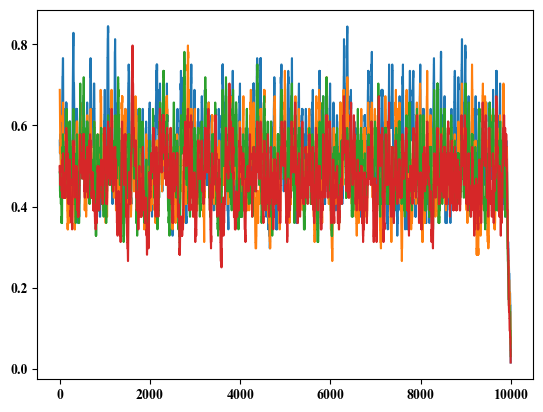

In [31]:
plt.plot(stn_a)
plt.plot(stn_b)
plt.plot(stn_c)
plt.plot(stn_d)

In [32]:
torch.std(STN_4)

tensor(0.0897, dtype=torch.float64)

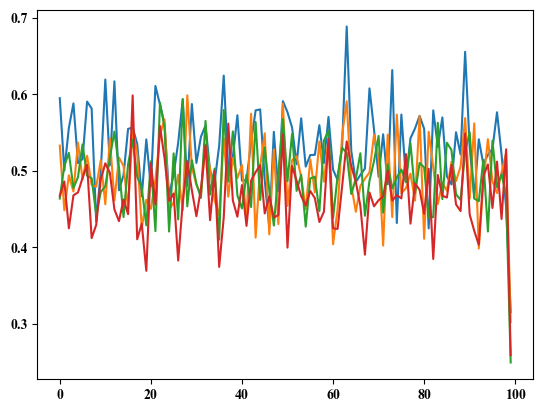

In [33]:
plt.plot(ts[:,0])
plt.plot(ts[:,1])
plt.plot(ts[:,2])
plt.plot(ts[:,3])

In [34]:
np.mean(np.std(rate_data['processed_stn'],0))


np.float64(0.12255322340859255)